### First file attempt at implementing Controlled Abstention Loss to my LSTM model.

File initially created 6/11/2025. 

I will start with a 14-day leadtime model. 

E. Fernandez 2025

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

#tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-18 19:20:25.785513: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 19:20:25.816949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 19:20:25.816971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 19:20:25.817919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 19:20:25.823035: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)
#check tensor flow version, needed to use earlier version for compatability with keras tuner

2.15.0


In [3]:
##this cell includes the new class and def functions from Barnes and Barnes 2021 relevant for creating a CAN. 
import metrics
import abstentionloss

In [4]:
#load inputs, preprocessed PC timeseries for each feature
infile = open("../../reduced_data/PCs/U_14.p","rb",)
U_PC = pickle.load(infile)  ##zonal-mean zonal wind vertical cross section 
infile.close()

infile = open("../../reduced_data/PCs/EHF_14.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../reduced_data/PCs/GPH_14.p","rb",)
GPH_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

In [5]:
##remove PC 1 which represents the early season spin up of the vortex
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

In [6]:
#check shape (timesteps,PCs)
U_PC.shape

(9238, 9)

In [7]:
#load output data, daily temperature anomaly classification (0 = <0 or negative; 1 = >0 or positive)
infile = open("../../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
infile.close()

In [8]:
#check shape
output.shape

(9238,)

In [9]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=1) 

In [10]:
##make pandas dataframe to select desired features
input = pd.DataFrame(inputvar)
input

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.791039,-1.727149,1.481165,-1.684007,0.329935,1.656387,-0.211460,1.453994,0.837609,0.195595,...,0.172799,1.564267,0.584225,-0.036226,0.870949,0.482494,0.197297,0.694999,-0.395420,-1.128227
1,0.821552,-1.842438,1.416795,-1.725300,-0.155038,2.059544,0.081825,1.419269,0.147530,0.234372,...,-0.436175,1.686121,0.834128,0.081523,0.887701,0.621646,0.388313,0.968120,-0.156091,-1.539525
2,0.888491,-1.958864,1.626327,-1.405833,-0.030527,1.728328,0.536282,0.792897,-1.002197,0.268253,...,0.480251,1.535731,1.169094,0.118023,0.852785,0.684715,0.481477,0.804988,0.313862,-1.607084
3,0.883083,-1.953125,1.878820,-0.966085,0.620002,1.275088,0.679312,1.133707,-0.758163,0.231512,...,-0.880181,1.224010,1.292322,-0.031788,0.794642,0.805009,0.279682,0.627936,0.181622,-0.832041
4,0.799762,-1.914598,1.794036,-0.578514,1.147515,0.969589,0.594968,1.942123,-0.141386,0.126057,...,-0.636755,0.993273,1.244127,-0.186460,0.879478,1.131472,0.345422,0.342985,0.390064,0.147311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9233,0.739117,0.344881,-1.039941,1.907440,-0.463413,1.368651,1.955351,-1.003432,-1.171885,-0.032577,...,0.667313,0.159405,1.871430,1.036272,-0.931433,-0.594206,1.060108,0.489458,0.632401,1.478229
9234,0.708051,0.610486,-0.735913,1.811668,1.011904,0.905560,2.091698,-0.923073,-0.182186,0.100459,...,0.677382,0.532989,1.945315,1.078350,-0.883960,-0.255287,1.054779,0.616516,0.933306,0.541883
9235,0.612392,0.813433,-0.491388,1.058656,2.158425,0.531745,2.458308,-0.798223,1.449475,0.138989,...,0.355340,1.044255,1.904598,0.936523,-1.013030,-0.031661,1.253826,0.375767,0.830058,-0.412274
9236,0.179745,0.300776,-0.592462,-0.004740,2.092489,-0.249596,1.450899,-0.071044,2.113109,0.101430,...,-0.112332,1.295592,1.709359,0.596902,-1.099654,-0.021087,1.714048,0.279814,0.649183,-0.773683


In [11]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

###designate samples per year based on leadtime
lead = 135

#reshape temp array to introduce lag.
temp = output.reshape(62, 149)
temp = temp[:, 14:]
print(temp.shape)

temp_flat = temp.flatten()

(62, 135)


In [12]:
#selected indices based on feature selection in separate Random Forest Model
#EUROPE
#input[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]

##CANADA
#input[[56, 1, 0, 55, 2, 53, 22, 57, 9, 25, 11, 4, 54, 38, 17, 30, 36, 3, 14, 26]]

##SE US
#input[[56, 1, 54, 18, 53, 3, 0, 10, 5, 19, 21, 14, 2, 57, 13, 60, 22, 26,25, 11]]

In [13]:
#create pd datafram of selected feature columns.
sele_ind_df = input[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]

n_features = 20

In [14]:
#look at new input array
sele_ind_df

,1,56,0,54,9,57,2,31,26,14,20,6,11,38,21,18,15,22,12,13
0,-1.727149,0.870949,0.791039,0.584225,0.195595,0.482494,1.481165,-0.840203,-0.190102,0.057985,-0.773881,-0.211460,-0.443124,-0.130601,0.202801,-0.186997,-0.187630,-0.032653,-0.019193,0.376977
1,-1.842438,0.887701,0.821552,0.834128,0.234372,0.621646,1.416795,0.061981,0.047160,0.038753,-0.324938,0.081825,-0.373201,0.321552,0.467937,-0.598541,-0.270955,0.027107,-0.049397,0.386002
2,-1.958864,0.852785,0.888491,1.169094,0.268253,0.684715,1.626327,0.298515,-0.432859,0.009860,-0.306709,0.536282,-0.265632,0.342450,0.137449,-0.366524,-0.253419,0.012183,0.024585,0.317177
3,-1.953125,0.794642,0.883083,1.292322,0.231512,0.805009,1.878820,0.660462,-0.094418,0.000942,0.019133,0.679312,-0.231309,0.463792,0.329118,-0.513304,-0.236251,-0.282491,0.136366,0.271059
4,-1.914598,0.879478,0.799762,1.244127,0.126057,1.131472,1.794036,0.447582,-0.096808,-0.171956,0.254848,0.594968,-0.224626,0.005776,-0.106193,-0.430760,-0.154636,-0.166812,0.192114,0.207816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9233,0.344881,-0.931433,0.739117,1.871430,-0.032577,-0.594206,-1.039941,-0.509073,-0.257606,-0.355304,-0.337902,1.955351,0.696732,-0.993664,-0.459643,-0.780476,0.085641,0.103523,1.020420,-0.827579
9234,0.610486,-0.883960,0.708051,1.945315,0.100459,-0.255287,-0.735913,-0.484002,0.104951,-0.734529,-0.387806,2.091698,0.528793,-0.712909,0.187002,-0.496463,-0.079321,0.201060,0.726277,-0.338853
9235,0.813433,-1.013030,0.612392,1.904598,0.138989,-0.031661,-0.491388,-0.967253,-0.227728,-0.252240,-0.915382,2.458308,0.276310,0.378725,0.115268,-0.112195,0.129463,-0.507578,0.114448,0.129632
9236,0.300776,-1.099654,0.179745,1.709359,0.101430,-0.021087,-0.592462,-1.556661,-0.148204,0.084979,-2.017825,1.450899,0.127205,0.196277,0.509032,0.827147,0.147253,-0.492190,0.008271,0.058502


In [15]:
#turn input array into (# samples, 14 days, 20 features)
sele_ind_data = sele_ind_df.values
sele_ind_data1 = sele_ind_data.reshape(62,149,n_features)

In [16]:
sele_ind_data.shape

(9238, 20)

In [17]:
#create timeseries data arrays for PCs with lag time introduced
new_input =  np.empty((62,lead,14,n_features))
new_output = np.empty((62,lead))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = sele_ind_data1[i,j:j+14,:]
        new_output[i,j] = temp[i,j]

In [18]:
#check corresponding shapes
new_input = np.array(new_input)
new_output = np.array(new_output)
print(new_input.shape)
print(new_output.shape)

(62, 135, 14, 20)
(62, 135)


In [19]:
#designate fraction for testing and validation
frac_ind = round((62*lead)*0.15) #amount of samples withheld
frac_end = round((62*lead)-frac_ind) #end of dataset/start index for training data

### In the cells below, I am going to have to introduce the new abstention category to my data. 

In [20]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*lead),14,n_features))
Y_all = np.copy(new_output.flatten())

print(X_all.shape)
print(Y_all.shape)

(8370, 14, 20)
(8370,)


In [21]:
##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

print("Training")
print(X_tri.shape)
print(Y_tri.shape)
print(" ")
print("Testing")
print(X_tes.shape)
print(Y_tes.shape)

Training
(7114, 14, 20)
(7114,)
 
Testing
(1256, 14, 20)
(1256,)


In [22]:
#Convert the Y array into a categorical array
#Traditionally, I have done this using keras.utils.to_categorical ... but I am going to try to use another method
#shown in the example file from Barnes and Barnes
from sklearn import preprocessing
import time

def onehot_abstent(y_train, y_test, num_cats):
    encoder = preprocessing.OneHotEncoder(categories='auto', sparse_output=False)
    encoder.fit(np.arange(num_cats).reshape(-1,1))
    
    onehotlabels_train = encoder.transform(np.array(y_train).reshape(-1, 1))
    onehotlabels_test = encoder.transform(np.array(y_test).reshape(-1, 1))
    
    onehotlabels_train = np.concatenate([onehotlabels_train, np.zeros((onehotlabels_train.shape[0], 1))], axis=1)
    onehotlabels_test = np.concatenate([onehotlabels_test, np.zeros((onehotlabels_test.shape[0], 1))], axis=1)
    
    return onehotlabels_train, onehotlabels_test;

In [23]:
##one hot encode and add on the abstention category
Y_tri, Y_tes = onehot_abstent(Y_tri, Y_tes, 2)

In [24]:
##Training
print(Y_tri.shape)
Y_tri

(7114, 3)


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [25]:
##Testing
print(Y_tes.shape)
Y_tes

(1256, 3)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [26]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(Y_tri)) or np.any(np.isinf(Y_tri)):
    print("NaN or Inf values found in Y_tri!")

if np.any(np.isnan(Y_tes)) or np.any(np.isinf(Y_tes)):
    print("NaN or Inf values found in Y_tes!")

### Begin establishing specifics of model.

In [27]:
##number of input nodes
numb_int = X_all.shape[1:]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [28]:
##as always, check that the shape is correct
Y_train.shape

(5858, 3)

In [29]:
#check correct indices for LSTM input layer. 
numb_int

(14, 20)

### Model Architecture. 

In [30]:
#These definition statements are from Barnes and Barnes 2021, modified to include my desired architecture. 
def make_model(ntimestep, nfeature, n1, n3, rl1, rl3, lr, alpha_init, setpoint, spinup_epochs, nupd,
              loss_str = 'NotWrongLoss', updater_str = 'Colorado'):
    
    tf.keras.backend.clear_session()
    ##use DNN to check that my model is capable of learning
    if(loss_str == 'DNN'):
        input_tensor = Input(shape=(ntimestep, nfeature))

        layer1 = layers.RNN(
            layers.LSTMCell(n1, activation='tanh', use_bias=True,
                            dropout=0.4, 
                            kernel_initializer='glorot_uniform',
                            kernel_regularizer=keras.regularizers.l2(l2=rl1)),
            return_sequences=False)(input_tensor)

        output_tensor = layers.Dense(2, activation='softmax')(layer1)

        model = Model(input_tensor, output_tensor)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

        return model, None  
    ##use CAN to intorduce abstention loss
    else:
        input_tensor = Input(shape=(ntimestep, nfeature))
    
        layer1 = layers.RNN(
            layers.LSTMCell(n1, activation='tanh', use_bias=True,
                              dropout=0.2, 
                              kernel_initializer='glorot_uniform',
                              kernel_regularizer=keras.regularizers.l2(l2= rl1)),
            return_sequences=False)(input_tensor)

        #layer2 = layers.RNN(
            #layers.LSTMCell(n2, activation='tanh', use_bias=True,
                             #kernel_initializer='glorot_uniform',
                             #kernel_regularizer=keras.regularizers.l2(l2= rl1)))(layer1)

        layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                             kernel_initializer='he_normal',bias_initializer='he_normal',
                              kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer1)
        ### change the output tensor to reflect the inclusion of the abstention category.
        output_tensor = layers.Dense(3, activation='softmax',)(layer3)

        model = Model(input_tensor, output_tensor)
        updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                       alpha_init=alpha_init, 
                                                       length=nupd)
        loss_function = getattr(abstentionloss, loss_str)(updater=updater,
                                                          spinup_epochs=spinup_epochs)
        model.compile(
            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=lr),#tf.keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[keras.metrics.categorical_accuracy,
                alpha_value,
                metrics.AbstentionFraction(abstain=2),
                metrics.PredictionLoss(abstain=2),
                metrics.PredictionAccuracy(abstain=2)
            ]
        )        
        
    # model.summary()
        
    return model, loss_function

#---------------------------------------------------
def alpha_value(y_true,y_pred):
    return loss_function.updater.alpha

#---------------------------------------------------
def scheduler(epoch, lr):
    if epoch < lr_epoch_bound:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

#---------------------------------------------------
class EarlyStoppingCAN(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingCAN, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as zero.
        self.best = 0.
        self.best_epoch = np.Inf
        # initialize best_weights to non-trained model
        self.best_weights = self.model.get_weights()
        

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_prediction_accuracy")
        if np.greater(current, self.best):
            abstention_error = np.abs(logs.get("val_abstention_fraction") - setpoint)
            if np.less(abstention_error,.1):
                self.best = current
                self.wait = 0
                # Record the best weights if current results is better (greater).
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Early stopping, setting to best_epoch = " + str(self.best_epoch + 1))    


In [31]:
#---------------------
#Model Initialization cell, modified from Barnes and Barnes 2021
######
batch_size = 64 
epochs = 50 
shuffle = True 
verbose = 2 #(0 = no output; 2 = output accuracy every epoch)

# Set parameters
LOSS = 'ClassWeight_NotWrongLoss' #or DNN; in the cross entropy model, I needed to create custom class_weights on the model fit to help with the uneven categories. 
# I added a few lines to the NotWrongLoss class function to add weights into the loss ... this may not be necessary, but I found that it helped. 
UPDATER = 'Washington' ##this worked best of the updaters provided
NLABEL = 3 #number of categories
NUPD = 50 #not sure what this is?
SPINUP_EPOCHS = 0
setpoint = 0.275
alpha_init = 1
BATCH_SIZE = batch_size
N_EPOCHS = epochs
#---------------------
NETWORK_SEED = 0
network_type = 'CAN' # 'CAN' or 'DNN'
#---------------------


#-------------------------------
# Get the model
tf.keras.backend.clear_session()

# define the model, loss function and callbacks
if(network_type=='DNN'):
    print('--> Training a DNN...')    
    model, loss_function = make_model(ntimestep = numb_int[0],
                                      nfeature = numb_int[1],
                                      n1 = 6, 
                                      rl1 = 0.077,  
                                      lr = 0.015, #0.0006466
                                      alpha_init = alpha_init,
                                      setpoint=setpoint, 
                                      spinup_epochs=SPINUP_EPOCHS,
                                      nupd=NUPD,
                                      loss_str = LOSS, 
                                      updater_str=UPDATER)
    callbacks = []
    
if(network_type=='CAN'):
    print('--> Training a CAN...')    
    es_can_callback = EarlyStoppingCAN(patience=40)            
    model, loss_function = make_model(ntimestep = numb_int[0],
                                      nfeature = numb_int[1],
                                      n1 = 6,
                                      n3 = 6,
                                      rl1 = 0.06,
                                      rl3 = 0.077,
                                      lr = 0.01755, #0.0006466
                                      alpha_init = alpha_init,
                                      setpoint=setpoint, 
                                      spinup_epochs=SPINUP_EPOCHS,
                                      nupd=NUPD,
                                      loss_str = LOSS, 
                                      updater_str=UPDATER)
    callbacks = [abstentionloss.AlphaUpdaterCallback(), es_can_callback]         
    

                                      #n1 = 6,
                                      #n2= 4,
                                      #n3 = 6,
                                      #rl1 = 0.06,
                                      #rl3 = 0.077,
                                      #lr = 0.01755, #0.0006466


#-------------------------------
# Remake onehotencoding for whether CAN or DNN
hotlabels = Y_train[:,:model.output_shape[-1]] # strip off abstention class if using the DNN
hotlabels_val = Y_validation[:,:model.output_shape[-1]] # strip off abstention class if using the DNN


--> Training a CAN...


In [32]:
#-------------------------------
# Train the model
model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=shuffle,
    verbose=verbose,
    callbacks=callbacks
)

Epoch 1/50
92/92 - 4s - loss: 0.9923 - categorical_accuracy: 0.5505 - alpha_value: 0.4496 - abstention_fraction: 0.1004 - prediction_loss: 0.6828 - prediction_accuracy: 0.6120 - val_loss: 0.6005 - val_categorical_accuracy: 0.5533 - val_alpha_value: 0.1650 - val_abstention_fraction: 0.0908 - val_prediction_loss: 0.6813 - val_prediction_accuracy: 0.6086 - 4s/epoch - 48ms/step
Epoch 2/50
92/92 - 1s - loss: 0.7812 - categorical_accuracy: 0.5319 - alpha_value: 0.4435 - abstention_fraction: 0.1477 - prediction_loss: 0.6787 - prediction_accuracy: 0.6241 - val_loss: 0.5419 - val_categorical_accuracy: 0.3201 - val_alpha_value: 0.0000e+00 - val_abstention_fraction: 0.0000e+00 - val_prediction_loss: 0.7923 - val_prediction_accuracy: 0.3201 - 940ms/epoch - 10ms/step
Epoch 3/50
92/92 - 1s - loss: 0.7244 - categorical_accuracy: 0.5155 - alpha_value: 0.3877 - abstention_fraction: 0.1646 - prediction_loss: 0.6866 - prediction_accuracy: 0.6171 - val_loss: 1.4286 - val_categorical_accuracy: 0.3766 - val

In [33]:
##this cell is for verifying that the model is kinda working
history = model.history.history

#display all values from history
for key in history:
    print(str(key)+":"+str(history[key][-1]))

##check to see how much the validation is abstaining on the abstain class
preds_val = model.predict(X_validation)
abstain_class = 2
pred_labels_val = np.argmax(preds_val, axis=1)
abstain_rate_val = np.mean(pred_labels_val == abstain_class)

print("Manual validation abstention rate: ", [abstain_rate_val])

loss:0.7488979697227478
categorical_accuracy:0.4865141808986664
alpha_value:0.45132169127464294
abstention_fraction:0.25964492559432983
prediction_loss:0.714217483997345
prediction_accuracy:0.6571362614631653
val_loss:0.8088898658752441
val_categorical_accuracy:0.4323248267173767
val_alpha_value:0.5752390623092651
val_abstention_fraction:0.20780254900455475
val_prediction_loss:0.777176558971405
val_prediction_accuracy:0.5457286238670349
40/40 [==============================] - 0s 5ms/step
Manual validation abstention rate:  [0.20780254777070065]


40/40 [==============================] - 0s 2ms/step


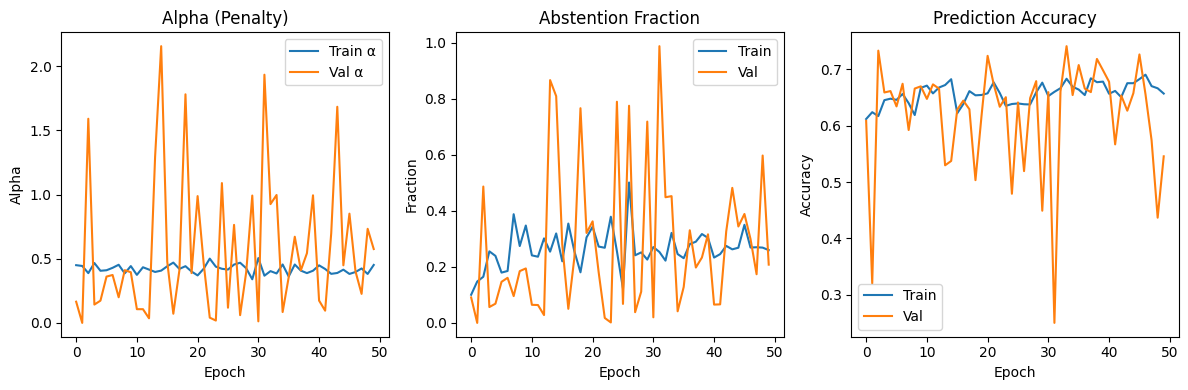

In [34]:
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

#look at the optimization history

epochs = range(len(history['alpha_value']))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epochs, history['alpha_value'], label='Train α')
plt.plot(epochs, history['val_alpha_value'], label='Val α')
plt.legend(); plt.title("Alpha (Penalty)")
plt.xlabel("Epoch"); plt.ylabel("Alpha")

plt.subplot(1,3,2)
plt.plot(epochs, history['abstention_fraction'], label='Train')
plt.plot(epochs, history['val_abstention_fraction'], label='Val')
plt.legend(); plt.title("Abstention Fraction")
plt.xlabel("Epoch"); plt.ylabel("Fraction")

plt.subplot(1,3,3)
plt.plot(epochs, history['prediction_accuracy'], label='Train')
plt.plot(epochs, history['val_prediction_accuracy'], label='Val')
plt.legend(); plt.title("Prediction Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

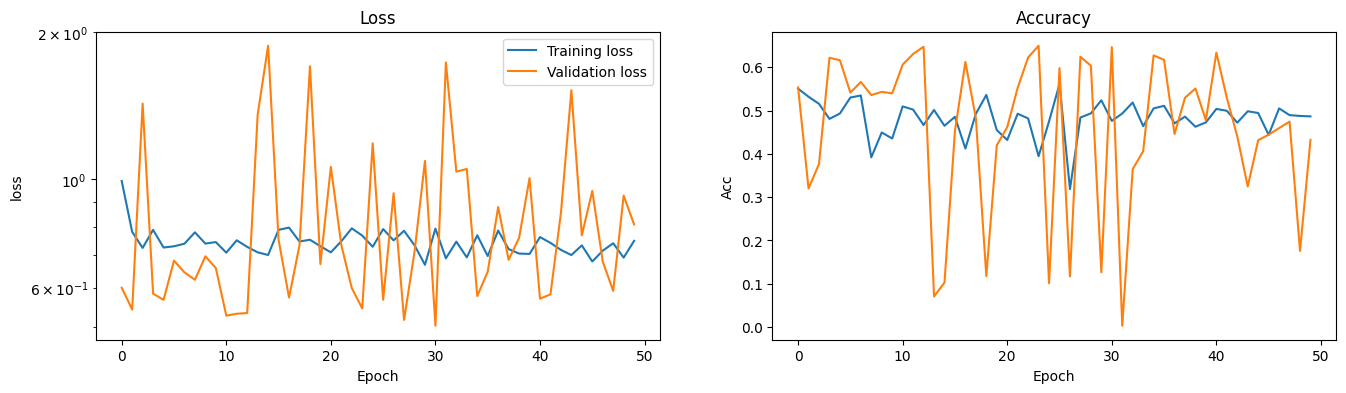

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(history['loss'], label='Training loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(history['categorical_accuracy'], label='Training ACC')
ax2.plot(history['val_categorical_accuracy'], label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

In [36]:
from sklearn.metrics import classification_report
import numpy as np

##view classification report to look at recall etc... see if model is still not learning from positive samples
y_val_pred = model.predict(X_validation)
y_val_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_validation, axis=1)

print(classification_report(y_val_true, y_val_classes, digits=3))

40/40 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0      0.817     0.350     0.490       854
           1      0.388     0.607     0.473       402
           2      0.000     0.000     0.000         0

    accuracy                          0.432      1256
   macro avg      0.402     0.319     0.321      1256
weighted avg      0.680     0.432     0.485      1256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
#BSS calculation taken from my skill score .py file.
y_true = np.argmax(Y_test, axis=1) #labels for positive class

#predicted prob for the positive events
y_prob = pred_test[:,1]

#climo baseline
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

#brier scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)
#brier skill score
bss = 1 - (bs_model / bs_climo)

print("Brier Score (Model): "+str(bs_model))
print("Brier Score (Climatology): "+str(bs_climo))
print("Brier Skill Score: "+str(bss))

Brier Score (Model): 0.22726947841386297
Brier Score (Climatology): 0.23295062680027587
Brier Skill Score: 0.02438777892314381


In [38]:
## BSS for negative outcomes 

##labels for negative class
y_true_neg = 1 - y_true 

#predicted prob for the negative events
y_prob = pred_test[:,0]

#climo baseline
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

#brier scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)
#brier skill score
bss = 1 - (bs_model / bs_climo)

print("Brier Score (Model): "+str(bs_model))
print("Brier Score (Climatology): "+str(bs_climo))
print("Brier Skill Score: "+str(bss))

Brier Score (Model): 0.28018354774733356
Brier Score (Climatology): 0.23295062680027587
Brier Skill Score: -0.20275936405852057


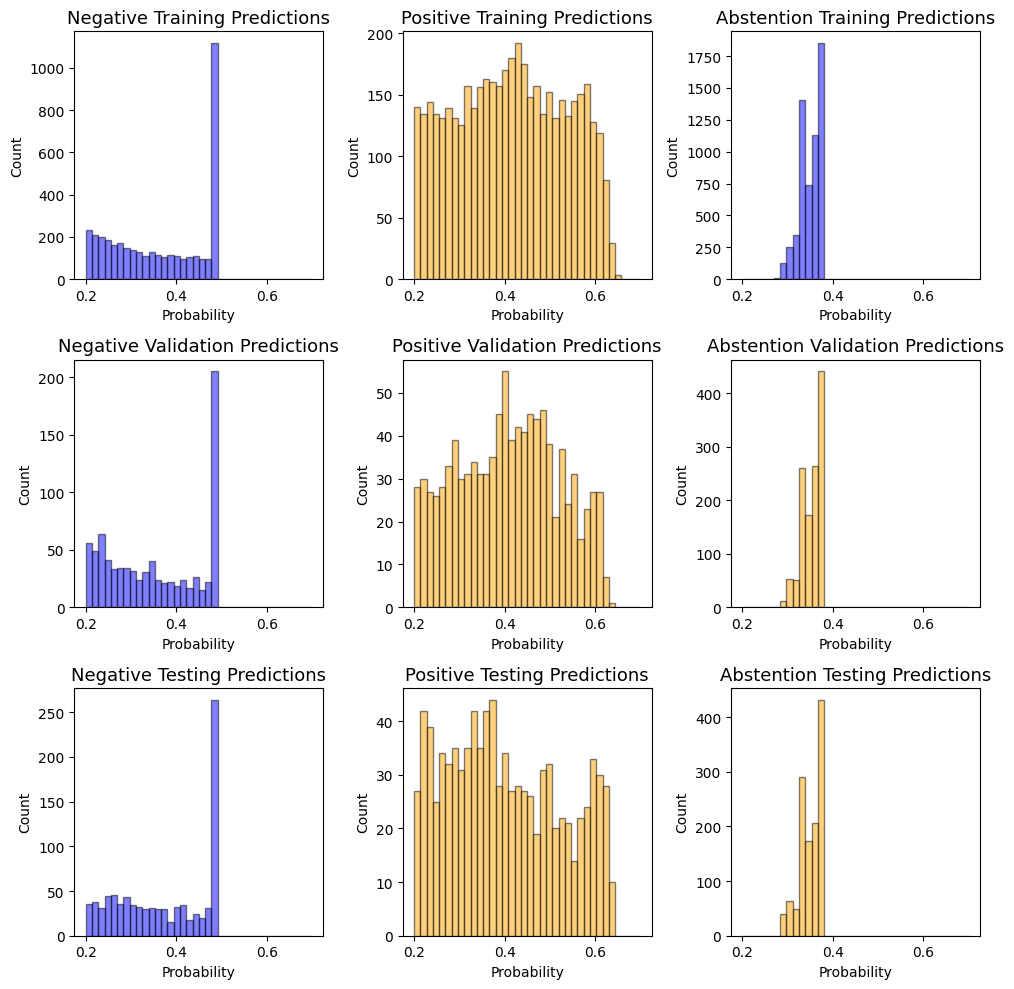

In [39]:
#plot probability distributions
bins = np.linspace(0.2, 0.7, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test[:,1], bins=bins)
counts_abs_test, edges_abs_test = np.histogram(pred_test[:,2], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train[:,1], bins=bins)
counts_abs_train, edges_abs_train = np.histogram(pred_train[:,2], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val[:,1], bins=bins)
counts_abs_val, edges_abs_val = np.histogram(pred_val[:,2], bins=bins)


fig, axes = plt.subplots(3, 3, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_abs_train[:-1], counts_abs_train, width=np.diff(edges_abs_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Abstention Training Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax4.set_title('Negative Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax5.set_title('Positive Validation Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_abs_val[:-1], counts_abs_val, width=np.diff(edges_abs_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Abstention Validation Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

ax7.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax7.set_title('Negative Testing Predictions', fontsize=13)
ax7.set_xlabel('Probability')
ax7.set_ylabel('Count')

ax8.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax8.set_title('Positive Testing Predictions', fontsize=13)
ax8.set_xlabel('Probability')
ax8.set_ylabel('Count')

ax9.bar(edges_abs_test[:-1], counts_abs_test, width=np.diff(edges_abs_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax9.set_title('Abstention Testing Predictions', fontsize=13)
ax9.set_xlabel('Probability')
ax9.set_ylabel('Count')

plt.tight_layout()

In [40]:
##ACC score calc, specifically for 90th percentile events (higher confidence events)
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

##90th from TESTING data
q90 = np.percentile(pred_test,90,axis=0)
##90th percentile acc
great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
#create the arrays of probabilities and actual values that exceed the 90th percentile
test90 = pred_test[great90]
test90_norm = Y_tes[great90]
test90_acc = calculate_accuracy(test90_norm, test90, threshold=0.5)
##full model
fulltest_acc = calculate_accuracy(Y_tes, pred_test, threshold=0.5)
    
##BSS
y_true = np.argmax(test90_norm, axis=1)
y_prob = test90[:,1]

p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)
BSS90 = 1 - (bs_model / bs_climo)

In [41]:
print("BSS 90th Percentile: ",BSS90)
print("90th Percentile ACC: ",test90_acc)
print("Model ACC: ",fulltest_acc)

BSS 90th Percentile:  -0.06193328898582373
90th Percentile ACC:  0.8148148148148148
Model ACC:  0.6746284501061571
